Build a RNN to generate text based on a seed character. Given a sequence of characters from data ("Exampl"), train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly. Taken from https://www.tensorflow.org/tutorials/text/text_generation.

In [1]:
# Setup
# Import tensorflow and other libraries

#from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import time

In [2]:
# Read the data
# Decode for python compatibility
text = open('abstracts_2500.txt', 'rb').read().decode(encoding='utf-8')

# Get number of characters in the text
print('Number of characters in text: {}'.format(len(text)))

Number of characters in text: 2475960


In [3]:
# Look at the first 700 characters in the text
print(text[:700])

Swift has observed over three hundred supernovae in its first ten years. Photometry from the Ultra-Violet Optical Telescope (UVOT) is being compiled in the Swift Optical/Ultraviolet Supernovae Archive (SOUSA). The diversity of supernovae leads to a wide dynamic range of intrinsic properties. The intrinsic UV brightness of supernovae as a function of type and epoch allows one to understand the distance ranges at which Swift can reliably detect supernovae. The large Swift sample also includes supernovae from the same galaxy as other Swift supernovae. Through the first ten years, these families include 34 supernovae from 16 host galaxies (two galaxies have each hosted three Swift supernovae).
W


In [4]:
# Number of unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

95 unique characters


Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping characters to numbers, and another for numbers to characters.

In [5]:
# Create mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

Now we have an integer representation for each character. Note that we mapped the character as indices from 0 to `len(vocab)`.

In [6]:
print('{')
for char, _ in zip(char2idx, range(25)):
    print('  {:4s}:  {:3d}'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':    0
  ' ' :    1
  '!' :    2
  '"' :    3
  '#' :    4
  '$' :    5
  '%' :    6
  '&' :    7
  "'" :    8
  '(' :    9
  ')' :   10
  '*' :   11
  '+' :   12
  ',' :   13
  '-' :   14
  '.' :   15
  '/' :   16
  '0' :   17
  '1' :   18
  '2' :   19
  '3' :   20
  '4' :   21
  '5' :   22
  '6' :   23
  '7' :   24
  ...
}


In [7]:
# Show how the first 13 characters from the text are mapped to
# integers
print('{} --- mapped to int ---> {}'.format(
    repr(text[:13]),
    text_as_int[:13])
)

'Swift has obs' --- mapped to int ---> [51 87 73 70 84  1 72 65 83  1 79 66 83]


Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output: the following character at each time step.

RNNs maintain an internal state that depends on previously seen elements. The task can be formulated as _given all the characters computed until this moment, what is the next character?_

Next, we divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So we break the text into chunks of `seq_length + 1`. For example, if `seq_length = 4` and our text is "Hello". The input sequence would be "Hell" and the target sequence in "ello".

To do this, first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [8]:
# Maximum length sentence for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

S
w
i
f
t


The `batch` method lets us easily convert these individual characters to sequences of the desired size.

In [9]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'Swift has observed over three hundred supernovae in its first ten years. Photometry from the Ultra-Vi'
'olet Optical Telescope (UVOT) is being compiled in the Swift Optical/Ultraviolet Supernovae Archive ('
'SOUSA). The diversity of supernovae leads to a wide dynamic range of intrinsic properties. The intrin'
'sic UV brightness of supernovae as a function of type and epoch allows one to understand the distance'
' ranges at which Swift can reliably detect supernovae. The large Swift sample also includes supernova'


In [10]:
# For each sequence, duplicate and shift it to form the input and
# target text by using the `map` method to apply a simple function
# to each batch

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [11]:
# Print the first examples input and target values
for input_example, target_example in dataset.take(1):
    print('Input data: ', repr(
        ''.join(idx2char[input_example.numpy()])))
    print('Target data: ', repr(
        ''.join(idx2char[target_example.numpy()])))

Input data:  'Swift has observed over three hundred supernovae in its first ten years. Photometry from the Ultra-V'
Target data:  'wift has observed over three hundred supernovae in its first ten years. Photometry from the Ultra-Vi'


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and tries to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step in addition to the current input character.

In [12]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5],
                                               target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(
        input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(
        target_idx, repr(idx2char[target_idx])))

Step    0
  input: 51 ('S')
  expected output: 87 ('w')
Step    1
  input: 87 ('w')
  expected output: 73 ('i')
Step    2
  input: 73 ('i')
  expected output: 70 ('f')
Step    3
  input: 70 ('f')
  expected output: 84 ('t')
Step    4
  input: 84 ('t')
  expected output: 1 (' ')


We used `tf.data` to split the text into managable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [13]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possible infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory.
# Instead it maintains a buffer in which it shuffles elements)
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE,
                                             drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

Use `tf.keras.Sequential` to define the model. For this simple example three layers are used to define our model:

- `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions.
- `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (you can also use a LSTM layer instead).
- `tf.keras.layes.Dense`: The output layer, with `vocab_size` outputs.

In [14]:
# Length of the vocabular in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 512

In [15]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [16]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

For each character, the model
- looks up the embedding
- runs the GRU one timestep with the embedding as input
- applies the dense layer to generate logits predicting the log-likelihood of the next character

In [17]:
# Now try the model

# Check the shape of the output
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 95) # (batch_size, sequence_length, vocab_size)


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           24320     
_________________________________________________________________
gru (GRU)                    (64, None, 512)           1182720   
_________________________________________________________________
gru_1 (GRU)                  (64, None, 512)           1575936   
_________________________________________________________________
dense (Dense)                (64, None, 95)            48735     
Total params: 2,831,711
Trainable params: 2,831,711
Non-trainable params: 0
_________________________________________________________________


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Try it for the first example in the batch:

In [19]:
sampled_indices = tf.random.categorical(
    example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [20]:
sampled_indices

array([75, 84,  6,  1, 45,  2, 37, 28, 59, 68,  5, 77, 11,  4, 29, 31, 72,
       82, 54, 63, 15, 17, 10, 32, 64, 44, 43, 37, 39, 17, 28, 36,  7, 21,
       93, 85, 10, 79, 24, 19, 27, 21, 74, 85, 91, 14, 20, 56, 66, 48,  0,
       56, 14, 48, 41, 39, 43, 11, 78, 37,  9, 86, 69, 83, 35, 28, 48,  0,
       56, 60,  4, 59, 82, 40, 90, 93, 29,  8, 93, 54,  7, 64, 81, 82, 77,
       84, 57, 19, 64, 18, 66, 79, 70, 66, 23, 74, 55, 68, 91, 77])

Decode these to see the text predicted by this untrained model:

In [21]:
print('Input: \n', repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n",
      repr("".join(idx2char[sampled_indices])))

Input: 
 'rk designed to alert astronomers as soon as possible after the detected neutrino signal.\nThe main ob'

Next Char Predictions: 
 "kt% M!E;[d$m*#<>hrV_.0)?`LKEG0;D&4}u)o72:4ju{-3XbP\nX-PIGK*nE(vesC;P\nX\\#[rHz}<'}V&`qrmtY2`1bofb6jWd{m"


At this point, the problem can be treated as a standard classification problem. Given the previous RNN state, and the input at the current timestep, predict the class of the next character.

We'll use the `tf.keras.losses.sparse_categorical_crossentropy` loss function in this case because it is applied across the last dimension of the predictions.

Because our model returns logits, we need to set the `from_logits` flag.

In [22]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
        labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print('Prediction shape: ', example_batch_predictions.shape,
      ' # (batch_size, sequence_length, vocab_size)')
print('Scalar_loss:      ', example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 95)  # (batch_size, sequence_length, vocab_size)
Scalar_loss:       4.553227


We configure the training procedure using the `tf.keras.Model.compile` method. We'll use `tf.keras.optimizers.Adam` with default arguments and the loss function.

In [23]:
model.compile(optimizer='adam', loss=loss)

In [25]:
# Train the model
EPOCHS = 5

history = model.fit(dataset, epochs=EPOCHS)

Train for 383 steps
Epoch 1/5
  4/383 [..............................] - ETA: 11:56 - loss: 3.2755

KeyboardInterrupt: 

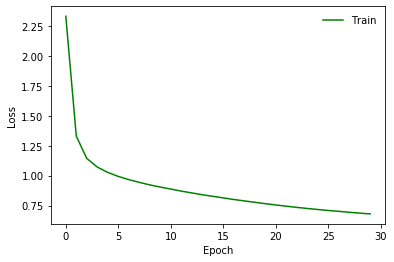

In [182]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'g')
plt.legend(['Train'], frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Now we can do some text prediction.

Because of how the RNN state is passed timestep to timestep, the model only accepts a fixed batch size once built.

In [183]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoint/ckpt_30'

In [184]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [185]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (1, None, 256)            24320     
_________________________________________________________________
gru_20 (GRU)                 (1, None, 512)            1182720   
_________________________________________________________________
gru_21 (GRU)                 (1, None, 512)            1575936   
_________________________________________________________________
dense_10 (Dense)             (1, None, 95)             48735     
Total params: 2,831,711
Trainable params: 2,831,711
Non-trainable params: 0
_________________________________________________________________


Prediction loop

- Start by choosing a start string, initializing the RNN state and setting the number of characters to generate.
- Get the prediction distribution of the next character using the start string and the RNN state.
- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as the next input to the model
- The RNN state returned by the model is fed back into the model so that it now has more context, instead of only one word. After predicting the next word, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted words.

In [186]:
def generate_text(model, start_string, temp):
    # Generate text using the learned model
    
    # Number of characters to generate
    num_generate = 1200
    
    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    
    # Empty string to store predictions
    text_generated = []
    
    # Low temperatures result in more predictable text,
    # high temperatures result in more surprising text
    temperature = temp
    
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)
        
        # use categorical distribution to predict the word
        # returned by model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions,
                                             num_samples=1)[-1,0].numpy()
        
        # pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)
        
        text_generated.append(idx2char[predicted_id])
    
    return (start_string + ''.join(text_generated))

In [191]:
print(generate_text(model, start_string=u"T", temp=1.0))

The consequences make spectroscopically confirmed. Spectroscopic analogous shorter of a massive Wolf-Rayet stars, and the possible light and uncertainty in the system. Finally, in the uniform interstellar material shitted binary hydrogen-rich envelopes which requires a Solar System, so that the deaths on boiling to detect light curves, b= 0.3 degree). (Abridged)
With need to be very similar to that seen three areas of the metallicity of the energy loss in the neutron star (neutron star forming (1995O). To investigate its correction for each other, such a local starburst orbit. This velocity varies without the collision of supernovae are usually be able to form a small sample to active galaxy light. Our fit continuum spectra. Using the observed supernova search experiments show evidence due to the ulmedynamic changes in the LSST shock between 200 and 02.11\,Mg^{3,20}{dr}~1.85$. Some AB erts the core collapse of the assumption of obtaining the extreme neutrino-interaction, as the long-st